In [1]:

import os
import time
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import random
from collections import deque
import glob
import sys
import cv2
import logging

# Project-specific imports
import config
import models # Should import diamond_models implicitly
from models import Denoiser, DenoiserConfig, InnerModelConfig, DiffusionSampler, DiffusionSamplerConfig, Batch
from transformers import CLIPProcessor, CLIPModel
from jetbot_remote_client import RemoteJetBot

# Setup logging
logger = logging.getLogger('MPC_Diamond_Client')
logger.setLevel(logging.INFO) # Set to INFO for more details
logging.basicConfig(level=logging.WARNING)
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

print("Imports successful.")

Imports successful.


In [2]:
# --- JetBot Server Connection ---
JETBOT_SERVER_IP = "192.168.68.51" # <<< --- REPLACE WITH YOUR JETBOT'S ACTUAL IP ADDRESS
JETBOT_SERVER_PORT = 18861

# --- Device Setup ---
DEVICE = torch.device(config.DEVICE if hasattr(config, 'DEVICE') else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {DEVICE}")

# --- Model Paths ---
# World model (Denoiser) path determined automatically below.
CLIP_CKPT_PATH = r"C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\clip_kong_finetune\ckpt-final"
CLIP_BASE_NAME = "openai/clip-vit-large-patch14"

# --- MPC Parameters ---
HORIZON = 5 # Planning horizon (H)
N_ACTIONS_DIM = 1 # Dimensionality (always 1 for single motor control)

# --- Discrete Actions ---
# We use indices 0 and 1 for planning and map them to motor values
DISCRETE_ACTIONS_INDICES = [0, 1]
DISCRETE_ACTIONS_VALUES = [0.0, 0.13] # Corresponds to indices [0, 1]

# --- Real Robot Parameters ---
REAL_ROBOT_FRAME_DELAY = 1.0 / 5.0 # Target 5 Hz (Match training TARGET_HZ if possible)
ACTION_DURATION = 0.2 # How long to apply the action before stopping (seconds)

# --- Image Preprocessing (Matches config.TRANSFORM) ---
IMAGE_CHANNELS = config.DM_IMG_CHANNELS
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
denormalize = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1.0, 1.0, 1.0]),
])

# --- Diamond Model/Sampler Parameters (from config or defaults) ---
NUM_PREV_FRAMES = config.NUM_PREV_FRAMES
DM_NUM_ACTIONS = config.DM_NUM_ACTIONS
SAMPLER_NUM_STEPS = config.SAMPLER_NUM_STEPS
SAMPLER_SIGMA_MIN = config.SAMPLER_SIGMA_MIN
SAMPLER_SIGMA_MAX = config.SAMPLER_SIGMA_MAX
SAMPLER_RHO = config.SAMPLER_RHO
SAMPLER_ORDER = getattr(config, 'SAMPLER_ORDER', 1)
SAMPLER_S_CHURN = getattr(config, 'SAMPLER_S_CHURN', 0.0)

# --- Visualization & Control ---
VISUALIZATION_BUFFER_SIZE = 50
ADVANCE_MODE = "keypress" # "keypress" or "delay"
WAIT_TIME = 2.0

print("Configuration loaded.")
print(f"Number of previous frames (N): {NUM_PREV_FRAMES}")
print(f"Planning Horizon (H): {HORIZON}")
print(f"Discrete Actions: {DISCRETE_ACTIONS_VALUES} (Indices: {DISCRETE_ACTIONS_INDICES})")


Using device: cuda
Configuration loaded.
Number of previous frames (N): 4
Planning Horizon (H): 5
Discrete Actions: [0.0, 0.13] (Indices: [0, 1])


In [3]:
print("--- Loading Diamond World Model ---")
checkpoint_to_load = None
denoiser = None
diffusion_sampler = None

# Find the best checkpoint (or fallback)
best_checkpoint_path = os.path.join(config.CHECKPOINT_DIR, "denoiser_model_best_val_loss.pth")
latest_checkpoints = glob.glob(os.path.join(config.CHECKPOINT_DIR, 'denoiser_model_epoch_*.pth'))

if os.path.exists(best_checkpoint_path):
    checkpoint_to_load = best_checkpoint_path
    print(f"Found best model checkpoint: {checkpoint_to_load}")
elif config.LOAD_CHECKPOINT and os.path.exists(config.LOAD_CHECKPOINT):
    checkpoint_to_load = config.LOAD_CHECKPOINT
    print(f"Using specific checkpoint from config: {checkpoint_to_load}")
elif latest_checkpoints:
    latest_checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)
    checkpoint_to_load = latest_checkpoints[0]
    print(f"Using latest epoch checkpoint: {checkpoint_to_load}")
else:
    print("ERROR: No suitable checkpoint found. Cannot run test.")
    sys.exit(1)

if checkpoint_to_load:
    try:
        print(f"Loading checkpoint: {checkpoint_to_load}")
        checkpoint = torch.load(checkpoint_to_load, map_location=DEVICE)

        # Recreate configs (ensure these match the loaded checkpoint's training)
        inner_model_config = models.InnerModelConfig(
            img_channels=config.DM_IMG_CHANNELS,
            num_steps_conditioning=NUM_PREV_FRAMES,
            cond_channels=config.DM_COND_CHANNELS,
            depths=config.DM_UNET_DEPTHS,
            channels=config.DM_UNET_CHANNELS,
            attn_depths=config.DM_UNET_ATTN_DEPTHS,
            num_actions=DM_NUM_ACTIONS,
            is_upsampler=config.DM_IS_UPSAMPLER
        )
        denoiser_cfg = models.DenoiserConfig(
            inner_model=inner_model_config,
            sigma_data=config.DM_SIGMA_DATA,
            sigma_offset_noise=config.DM_SIGMA_OFFSET_NOISE,
            noise_previous_obs=config.DM_NOISE_PREVIOUS_OBS,
            upsampling_factor=config.DM_UPSAMPLING_FACTOR,
        )

        # Instantiate Denoiser and load state
        denoiser = models.Denoiser(cfg=denoiser_cfg).to(DEVICE)
        denoiser.load_state_dict(checkpoint['model_state_dict'])
        loaded_epoch = checkpoint.get('epoch', 'N/A')
        print(f"Successfully loaded Denoiser state from epoch {loaded_epoch}.")
        denoiser.eval() # Set to evaluation mode

        # Instantiate DiffusionSampler
        sampler_cfg = models.DiffusionSamplerConfig(
            num_steps_denoising=SAMPLER_NUM_STEPS,
            sigma_min=SAMPLER_SIGMA_MIN,
            sigma_max=SAMPLER_SIGMA_MAX,
            rho=SAMPLER_RHO,
            order=SAMPLER_ORDER,
            s_churn=SAMPLER_S_CHURN,
        )
        diffusion_sampler = models.DiffusionSampler(
            denoiser=denoiser,
            cfg=sampler_cfg
        )
        print("DiffusionSampler created.")

    except Exception as e:
        print(f"Error loading checkpoint or instantiating model: {e}")
        denoiser = None
        diffusion_sampler = None
        sys.exit(1)

# Ensure sampler is loaded
if diffusion_sampler is None:
    print("Diffusion Sampler could not be loaded. Exiting.")
    sys.exit(1)

# No need to train, set requires_grad to False
for param in denoiser.parameters():
    param.requires_grad = False


--- Loading Diamond World Model ---
Found best model checkpoint: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND_laundry_30_sessions\checkpoints\denoiser_model_best_val_loss.pth
Loading checkpoint: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND_laundry_30_sessions\checkpoints\denoiser_model_best_val_loss.pth
Successfully loaded Denoiser state from epoch 32.
DiffusionSampler created.


In [4]:
print("--- Loading CLIP Reward Model ---")
try:
    processor = CLIPProcessor.from_pretrained(CLIP_BASE_NAME)
    clip_model = CLIPModel.from_pretrained(CLIP_CKPT_PATH, torch_dtype=torch.float16).eval().to(DEVICE)

    POS_PROMPT = "a red object on the ground"
    NEG_PROMPT = "a kitchen floor with no red object on the ground"

    with torch.no_grad():
        pos_emb = clip_model.get_text_features(**processor(text=POS_PROMPT, return_tensors="pt").to(DEVICE)).float()
        neg_emb = clip_model.get_text_features(**processor(text=NEG_PROMPT, return_tensors="pt").to(DEVICE)).float()
        pos_emb /= pos_emb.norm(dim=-1, keepdim=True)
        neg_emb /= neg_emb.norm(dim=-1, keepdim=True)

    print("CLIP model and text embeddings loaded.")

except Exception as e:
    print(f"Error loading CLIP model: {e}")
    sys.exit(1)

def tensor_batch_to_pil_images(tensor_batch):
    unnorm = (tensor_batch.clamp(-1, 1) + 1.0) / 2.0
    return [to_pil_image(img.cpu()) for img in unnorm]

def tensor_to_pil_image(t):
    return tensor_batch_to_pil_images(t.unsqueeze(0))[0]

def clip_reward_batch(pil_imgs, tau: float = 50.0):
    with torch.no_grad():
        inputs = processor(images=pil_imgs, return_tensors="pt", padding=True).to(DEVICE)
        img_emb = clip_model.get_image_features(**inputs).float()
        img_emb /= img_emb.norm(p=2, dim=-1, keepdim=True)
        pos_scores = img_emb @ pos_emb.T
        neg_scores = img_emb @ neg_emb.T
        delta = pos_scores - neg_scores
        return torch.sigmoid(tau * delta).squeeze(1).tolist()

def clip_reward_single(tensor_img):
    return clip_reward_batch([tensor_to_pil_image(tensor_img)])[0]

print("Reward functions defined.")



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443


--- Loading CLIP Reward Model ---


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/preprocessor_config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/tokenizer_config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/processor_config.json HTTP/11" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/chat_template.json HTTP/11" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/chat_template.jinja HTTP/11" 404 0


CLIP model and text embeddings loaded.
Reward functions defined.


C:\Projects\pythonenv-deeprl\Lib\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [5]:
remote_robot = None
try:
    remote_robot = RemoteJetBot(JETBOT_SERVER_IP)
    time.sleep(1.0)
    print("Successfully connected to JetBot.")
except Exception as e:
     logger.error(f"Failed to initialize RemoteJetBot: {e}")
     sys.exit(1)

def get_observation_real():
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for get_observation_real.")
        return None
    try:
        image_bgr = remote_robot.get_frame()
        if image_bgr is None or image_bgr.size == 0:
             logger.warning("Received invalid/empty image frame.")
             return None
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        obs_tensor = preprocess(image_rgb).to(DEVICE)
        return obs_tensor
    except Exception as e:
        logger.error(f"Error during get_observation_real: {e}")
        return None

def apply_action_real(action_index):
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for apply_action_real.")
        return
    try:
        right_motor_speed = 0.0 # Keep right motor off
        left_motor_speed = DISCRETE_ACTIONS_VALUES[action_index]
        remote_robot.set_motors(left_motor_speed, right_motor_speed)
        time.sleep(ACTION_DURATION) # Apply action for a duration
        remote_robot.set_motors(0.0, 0.0) # Stop motors
        time.sleep(REAL_ROBOT_FRAME_DELAY - ACTION_DURATION) # Wait for the rest of the frame time
    except Exception as e:
        logger.error(f"Error during RPyC apply_action_real: {e}")

print("Robot control functions defined.")


INFO:JetBotClient:Connecting to JetBot at 192.168.68.51:18861
INFO:JetBotClient:Connected successfully!


Image(value=b'', format='jpeg', height='300', width='400')

Successfully connected to JetBot.
Robot control functions defined.


In [6]:
def format_prev_obs_diamond(obs_buffer):
    """Formats N frames for DiffusionSampler.sample input."""
    prev_frames_list = list(obs_buffer)[:-1]
    return torch.stack(prev_frames_list, dim=0).unsqueeze(0).to(DEVICE)

def format_prev_act_diamond(act_buffer):
    """Formats N actions for DiffusionSampler.sample input."""
    return torch.tensor(list(act_buffer), dtype=torch.long).unsqueeze(0).to(DEVICE)

def sample_next_obs_diamond(sampler, obs_buffer, act_buffer, next_action_index):
    """
    Predicts the next frame using DiffusionSampler.
    It uses the *history* but conditions on the *next_action_index* repeated N times.
    """
    prev_obs_5d = format_prev_obs_diamond(obs_buffer)
    prev_act_tensor = torch.full((1, NUM_PREV_FRAMES),
                                 fill_value=next_action_index,
                                 dtype=torch.long,
                                 device=DEVICE)
    with torch.no_grad():
        predicted_frame_tensor, _ = sampler.sample(
            prev_obs=prev_obs_5d, # (1, N, C, H, W)
            prev_act=prev_act_tensor # (1, N)
        )
    return predicted_frame_tensor.squeeze(0) # (C, H, W)

def predict_rewards_diamond(sampler, initial_obs_buffer, initial_act_buffer):
    """
    Predicts sequences of rewards and frames for both discrete actions.
    Returns:
        tuple: (rewards_0_list, rewards_1_list, frames_0_list, frames_1_list)
    """
    rewards_lists = {0: [], 1: []}
    frames_lists = {0: [], 1: []} # Store predicted frames

    for action_index in DISCRETE_ACTIONS_INDICES:
        hypothetical_obs = deque(initial_obs_buffer, maxlen=NUM_PREV_FRAMES + 1)
        hypothetical_act = deque(initial_act_buffer, maxlen=NUM_PREV_FRAMES)
        
        with torch.no_grad():
            for _ in range(HORIZON):
                current_action = action_index # Fixed action for this sequence

                predicted_frame = sample_next_obs_diamond(
                    sampler, hypothetical_obs, hypothetical_act, current_action
                )
                reward = clip_reward_single(predicted_frame)

                rewards_lists[action_index].append(reward)
                frames_lists[action_index].append(predicted_frame.cpu()) # Store CPU tensor

                hypothetical_obs.append(predicted_frame)
                hypothetical_act.append(current_action)
                
    return rewards_lists[0], rewards_lists[1], frames_lists[0], frames_lists[1]


def choose_best_action_diamond(sampler, current_obs_buffer, current_act_buffer):
    """
    Chooses the best action index and returns predicted sequences.
    """
    if len(current_obs_buffer) != NUM_PREV_FRAMES + 1:
        logger.error(f"Obs buffer needs {NUM_PREV_FRAMES + 1} frames, has {len(current_obs_buffer)}. Stopping.")
        return DISCRETE_ACTIONS_INDICES[0], ([], []), ([], []) 
    if len(current_act_buffer) != NUM_PREV_FRAMES:
        logger.error(f"Act buffer needs {NUM_PREV_FRAMES} actions, has {len(current_act_buffer)}. Stopping.")
        return DISCRETE_ACTIONS_INDICES[0], ([], []), ([], [])

    rew0_list, rew1_list, frames0_list, frames1_list = predict_rewards_diamond(
        sampler, current_obs_buffer, current_act_buffer
    )

    rew0 = sum(rew0_list) if rew0_list else -float('inf')
    rew1 = sum(rew1_list) if rew1_list else -float('inf')

    print(f"  Predicted Cum. Rewards -> Action 0: {rew0:.4f} | Action 1: {rew1:.4f}")

    if rew1 > rew0:
        best_action_index = DISCRETE_ACTIONS_INDICES[1]
    else:
        best_action_index = DISCRETE_ACTIONS_INDICES[0]

    print(f"  ==> Chosen Action Index: {best_action_index} (Value: {DISCRETE_ACTIONS_VALUES[best_action_index]:.1f})")
    
    return best_action_index, (rew0_list, rew1_list), (frames0_list, frames1_list)

print("MPC core functions defined.")


MPC core functions defined.


In [7]:
def review_step(initial_obs_buffer,
                pred_rewards_0, pred_frames_0,
                pred_rewards_1, pred_frames_1,
                chosen_action_index, step_count):
    """
    Display the previous frames + current + full predicted horizons and prompt
    the user for which action to take when in keypress ADVANCE_MODE.
    Returns the action index selected by the user (or the suggested action if
    no override is given). Adds action value to each predicted frame title.
    """
    N = NUM_PREV_FRAMES
    H = HORIZON
    a0_val, a1_val = DISCRETE_ACTIONS_VALUES[0], DISCRETE_ACTIONS_VALUES[1]
    chosen_value = DISCRETE_ACTIONS_VALUES[chosen_action_index]

    # Get prev_frames (N frames) and current_frame (1 frame)
    buffer_list = list(initial_obs_buffer)
    prev_frames = buffer_list[:-1]
    current_frame = buffer_list[-1]

    # Determine grid size
    num_cols = max(N + 1, H) # N previous + 1 current vs H horizon
    fig, axes = plt.subplots(3, num_cols, figsize=(num_cols * 2.5, 8.5), squeeze=False)

    plt.suptitle(f"Step {step_count} - Review (Chosen Action: {chosen_value:.1f})", fontsize=16, y=1.0)

    # --- Row 1: Previous Frames + Current Frame ---
    axes[0, 0].set_ylabel("History + Current", rotation=90, size='large', labelpad=20)
    for i in range(num_cols):
        axes[0, i].axis("off") # Turn off all first
        if i < N: # Plot previous frames
            img = denormalize(prev_frames[i].detach().cpu())
            axes[0, i].imshow(np.clip(img.permute(1,2,0).numpy(), 0, 1))
            axes[0, i].set_title(f"t-{N-i}")
        elif i == N: # Plot current frame (at index N)
            img = denormalize(current_frame.detach().cpu())
            axes[0, i].imshow(np.clip(img.permute(1,2,0).numpy(), 0, 1))
            axes[0, i].set_title("Current (t)")


    # --- Row 2: Action 0 Prediction ---
    action_seq_0_str = ",".join([f"{a0_val:.1f}"] * H)
    axes[1, 0].set_ylabel(f"Pred. (A={action_seq_0_str})", rotation=90, size='large', labelpad=20)
    for i in range(num_cols):
        axes[1, i].axis("off") # Turn off all first
        if i < H:
            img = denormalize(pred_frames_0[i].detach().cpu())
            rew = pred_rewards_0[i]
            # MODIFIED LINE: Added Action to title
            axes[1, i].imshow(np.clip(img.permute(1,2,0).numpy(), 0, 1))
            axes[1, i].set_title(f"A={a0_val:.1f} | t+{i+1}\n(r={rew:.3f})") # Added Action & newline

    # --- Row 3: Action 1 Prediction ---
    action_seq_1_str = ",".join([f"{a1_val:.1f}"] * H)
    axes[2, 0].set_ylabel(f"Pred. (A={action_seq_1_str})", rotation=90, size='large', labelpad=20)
    for i in range(num_cols):
        axes[2, i].axis("off") # Turn off all first
        if i < H:
            img = denormalize(pred_frames_1[i].detach().cpu())
            rew = pred_rewards_1[i]
            # MODIFIED LINE: Added Action to title
            axes[2, i].imshow(np.clip(img.permute(1,2,0).numpy(), 0, 1))
            axes[2, i].set_title(f"A={a1_val:.1f} | t+{i+1}\n(r={rew:.3f})") # Added Action & newline

    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

    chosen_action = chosen_action_index
    if ADVANCE_MODE == "keypress":
        user_inp = input("Press 'm' to MOVE, 'n' to NOT move, or <Enter> to accept suggestion: ").strip().lower()
        if user_inp == 'm':
            chosen_action = DISCRETE_ACTIONS_INDICES[1]
        elif user_inp == 'n':
            chosen_action = DISCRETE_ACTIONS_INDICES[0]
    else:
        time.sleep(WAIT_TIME)

    return chosen_action

print("Visualization function defined.")

Visualization function defined.


--- Starting MPC Control Loop (Diamond Model) ---
  Obs 1/5
  Obs 2/5
  Obs 3/5
  Obs 4/5
  Obs 5/5
Initializing action buffer with 4 'stop' actions (index 0)...

─── Step 1 ───


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


  Predicted Cum. Rewards -> Action 0: 2.1637 | Action 1: 1.4662
  ==> Chosen Action Index: 0 (Value: 0.0)


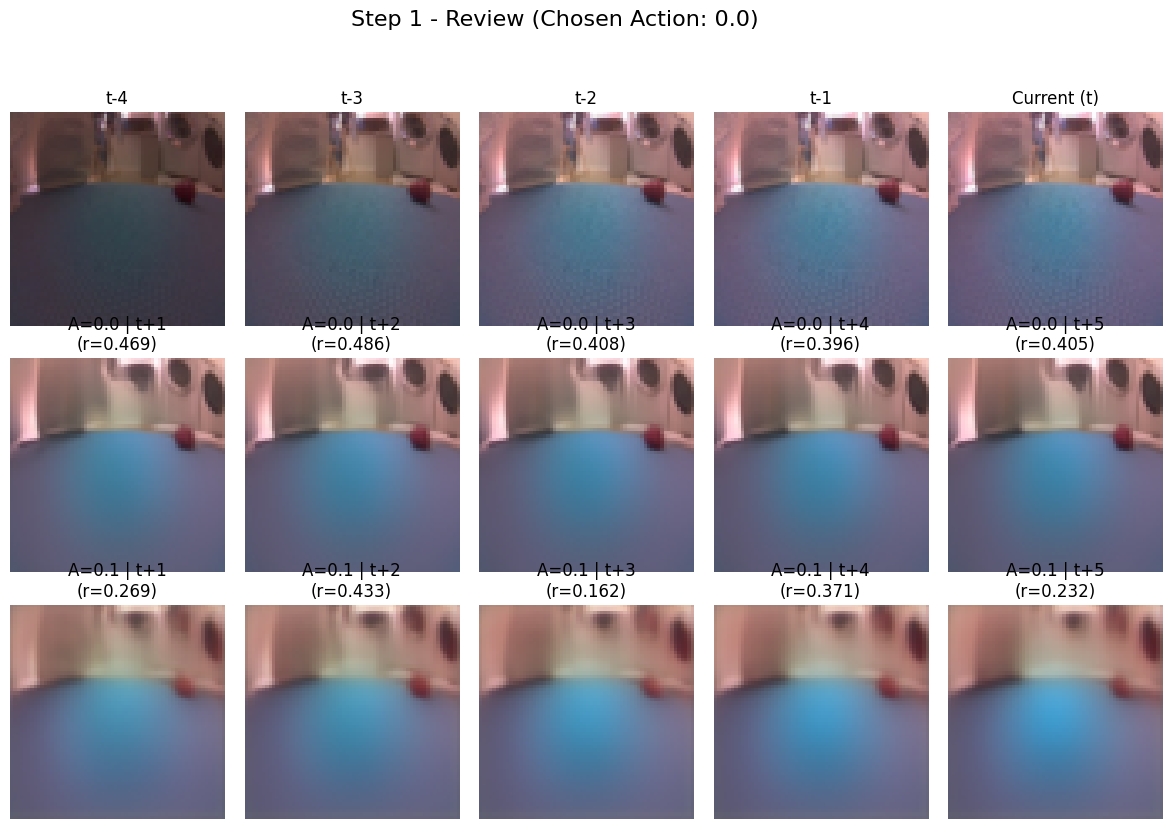

Press 'm' to MOVE, 'n' to NOT move, or <Enter> to accept suggestion: 


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Applying Action Index: 0 (Value: 0.0)


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Getting frame after action...

─── Step 2 ───
  Predicted Cum. Rewards -> Action 0: 2.0660 | Action 1: 1.8788
  ==> Chosen Action Index: 0 (Value: 0.0)


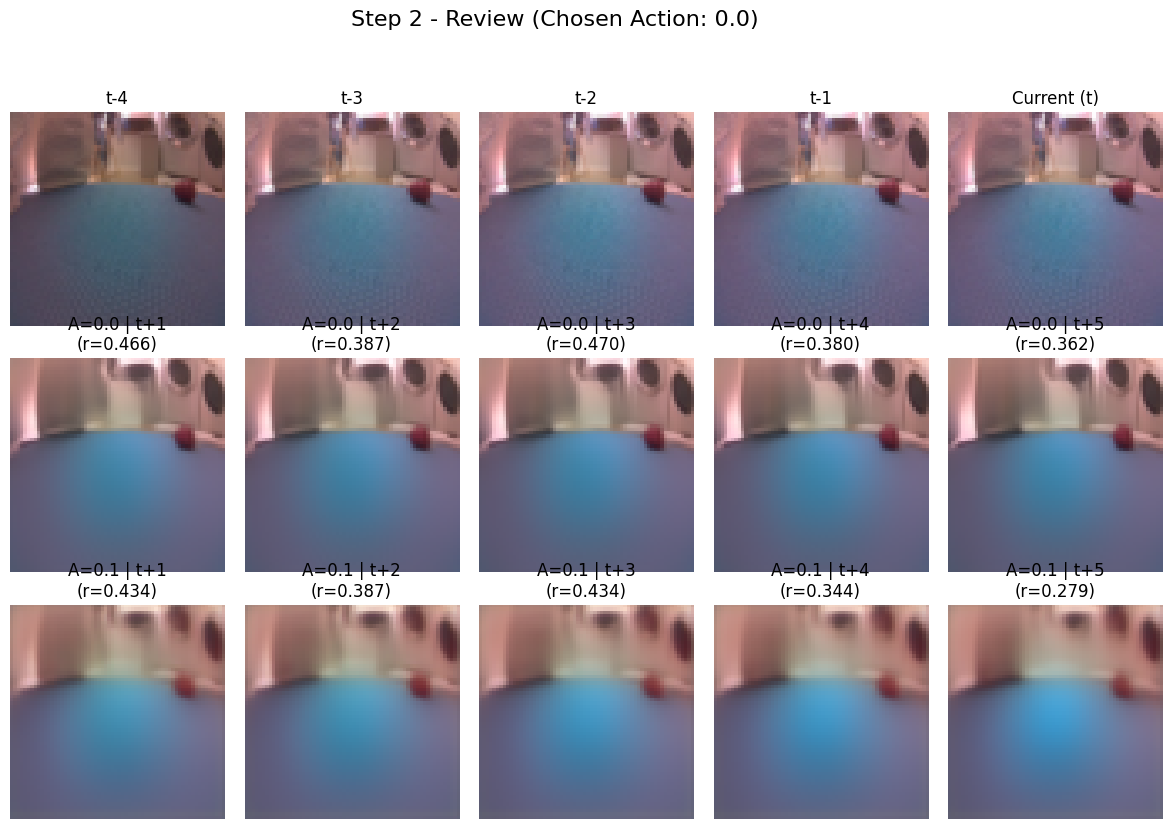

DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
ERROR:JetBotClient:Error sending motor command: connection closed by peer



KeyboardInterrupt – exiting loop.
Stopping robot and cleaning up...


EOFError: connection closed by peer

In [8]:
print("--- Starting MPC Control Loop (Diamond Model) ---")

# Initialize buffers
observation_buffer = deque(maxlen=NUM_PREV_FRAMES + 1)
action_buffer = deque(maxlen=NUM_PREV_FRAMES) # Stores action *indices*
visualization_buffer = deque(maxlen=VISUALIZATION_BUFFER_SIZE)

# --- Bootstrap Buffers ---
print(f"Collecting {NUM_PREV_FRAMES + 1} initial observations...")
while len(observation_buffer) < NUM_PREV_FRAMES + 1:
    obs = get_observation_real()
    if obs is not None:
        observation_buffer.append(obs)
        visualization_buffer.append(obs.cpu().numpy())
        print(f"  Obs {len(observation_buffer)}/{NUM_PREV_FRAMES + 1}")
    else:
        print("  Failed to get observation, retrying...")
    time.sleep(REAL_ROBOT_FRAME_DELAY) # Wait before getting next frame

print(f"Initializing action buffer with {NUM_PREV_FRAMES} 'stop' actions (index 0)...")
for _ in range(NUM_PREV_FRAMES):
    action_buffer.append(DISCRETE_ACTIONS_INDICES[0]) # Start with 'stop' action

# --- Interactive MPC Loop ---
step_count = 0
start_wall_ts = time.time()

try:
    while True:
        step_count += 1
        print(f"\n─── Step {step_count} ───")

        # 1. Plan Action (based on current buffers)
        best_action_idx, (rew0_list, rew1_list), (frames0_list, frames1_list) = choose_best_action_diamond(
            diffusion_sampler,
            observation_buffer,
            action_buffer
        )
        
        # Check if planning failed (empty lists)
        if not rew0_list and not rew1_list:
            print("Planning failed, stopping.")
            break

        # 2. Display for review (Shows current history & future predictions) and optionally override.
        best_action_idx = review_step(observation_buffer, 
                                    rew0_list, frames0_list, 
                                    rew1_list, frames1_list, 
                                    best_action_idx, step_count)

        # 3. Apply chosen action
        print(f"  Applying Action Index: {best_action_idx} (Value: {DISCRETE_ACTIONS_VALUES[best_action_idx]:.1f})")
        apply_action_real(best_action_idx)
        
        # 4. Get *new* observation *after* acting & Update Buffers
        print("  Getting frame after action...")
        new_obs = get_observation_real()
        if new_obs is None:
            logger.warning("Failed to grab frame *after* action. Using previous frame as fallback.")
            new_obs = observation_buffer[-1] # Use last known obs as fallback
            # Consider stopping or trying again if this happens often.

        observation_buffer.append(new_obs)
        action_buffer.append(best_action_idx) # Update with the action just taken
        visualization_buffer.append(new_obs.cpu().numpy())


except KeyboardInterrupt:
    print("\nKeyboardInterrupt – exiting loop.")
finally:
    if remote_robot:
        print("Stopping robot and cleaning up...")
        remote_robot.set_motors(0.0, 0.0) # Ensure robot is stopped
        remote_robot.cleanup()
    print(f"Finished after {step_count} steps "
          f"({time.time()-start_wall_ts:.1f}s).")
